In [1]:
# import torch
import requests
import json
from transformers import TFDistilBertForSequenceClassification, AutoTokenizer
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import psutil
import tensorflow as tf
from pynvml import *

c:\Users\HP\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\HP\anaconda3\envs\tf\lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
try:
    df_unseen = pd.read_csv("../test_llm.csv")
except FileNotFoundError:
    print("Error: File 'test bert.csv' not found.")
    print("Pastikan file tersebut berada di direktori yang sama dengan script ini.")
    exit()

In [3]:
df_unseen

,Customer Review,Emotion,text_clean
0,buahnya bagus... kurirnya ok sellernya juga ok,Happy,buah bagus kurir ok sellernya juga ok
1,"Ada sedikit cacat, selainnya oke",Happy,ada sedikit cacat selain oke
2,Jadi semangat mancing.,Happy,jadi semangat mancing
3,Cepat tiba n kemasan bagus. barangnya juga bagus,Happy,cepat tiba n kemas bagus barang juga bagus
4,Produk sesuai deskripsi??. Variasi produk bera...,Happy,produk sesuai deskripsi variasi produk agam fu...
...,...,...,...
220,Parah respon nya Butuh 4 hr sejak order baru d...,Anger,parah respon nya butuh 4 hari sejak order baru...
221,buruk super duper buruk kok bisa rusakk dlm ny...,Anger,buruk super duper buruk kok bisa rusakk dalam ...
222,kw kirim brg bekas dan rusak serta tdk menerim...,Anger,kau kirim bareng bekas dan rusak serta tidak t...
223,"Jualan kok ngotottt, nggak laku toko nya bang?",Anger,jual kok ngotottt enggak laku toko nya bang


In [4]:
df_unseen = df_unseen.dropna(subset=['text_clean'])

In [5]:
df_unseen['text_clean'] = df_unseen['text_clean'].str.lower()

In [6]:
nama_folder_simpan = "../../distil"
MAX_LENGTH = 256

print("Memuat tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(nama_folder_simpan)

print("Memuat model...")
model = TFDistilBertForSequenceClassification.from_pretrained(
    nama_folder_simpan,
    from_pt=True
)

print("Model siap digunakan!")

Memuat tokenizer...
Memuat model...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Model siap digunakan!


In [7]:
LABEL_MAP = {
    0: 'Anger',
    1: 'Fear',
    2: 'Happy',
    3: 'Love',
    4: 'Sadness'
}

In [8]:
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)

def get_vram_usage_gb():
    info = nvmlDeviceGetMemoryInfo(handle)
    return info.used / (1024 ** 3)

In [9]:
import pandas as pd
print("=== MULAI PREDIKSI MULTICLASS TENSORFLOW ===")

predictions = []
ram_usages = []
vram_usages = []
latencies = []
start_total = time.time()

df_sample = df_unseen.copy()

# Ganti 'title' dengan 'text_clean' dan 'label_score' dengan 'Emotion' (sesuai data Anda)
TEXT_COLUMN = 'text_clean'
LABEL_COLUMN = 'Emotion'

for idx, row in enumerate(df_sample.itertuples(), start=1):
    review_text = getattr(row, TEXT_COLUMN) # Mengambil teks dari kolom 'text_clean'
    
    start_time = time.time()
    
    # 1. Tokenizer (return_tensors='tf' untuk TensorFlow)
    inputs = tokenizer(
        [review_text],
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='tf' # <--- DIUBAH ke 'tf'
    )


    ram_before = psutil.virtual_memory().used / (1024 ** 3)
    vram_before = get_vram_usage_gb()

    outputs = model(
        **inputs,
        training=False
    )

    end_time = time.time()

    ram_after = psutil.virtual_memory().used / (1024 ** 3)
    vram_after = get_vram_usage_gb()

    avg_ram = (ram_before + ram_after) / 2
    avg_vram = (vram_before + vram_after) / 2

    ram_usages.append(avg_ram)
    vram_usages.append(avg_vram)

    # --- PERUBAHAN UTAMA UNTUK MULTICLASS TF ---
    # 4. Terapkan Softmax menggunakan tf.nn.softmax
    probabilities = tf.nn.softmax(outputs.logits, axis=-1).numpy().flatten()
    
    # 5. Dapatkan indeks kelas dengan probabilitas tertinggi menggunakan tf.argmax
    pred_class_id = tf.argmax(probabilities).numpy().item() # Gunakan item() untuk mendapatkan int biasa
    
    # 6. Dapatkan probabilitas untuk kelas yang diprediksi tersebut
    prob_score = probabilities[pred_class_id].item() 
    
    # 7. Petakan ID ke label emosi
    pred_label_emotion = LABEL_MAP[pred_class_id]
    # ----------------------------------------
    
    elapsed = end_time - start_time

    latencies.append(elapsed)

    predictions.append({
        "teks_ulasan": review_text,
        "prediksi_id": pred_class_id,
        "prediksi_emosi": pred_label_emotion,
        "probabilitas": prob_score,
        "waktu": elapsed,
        "ram": avg_ram,
        "vram": avg_vram,
        "label_asli": getattr(row, LABEL_COLUMN) 
    })

    print(f"[{idx}] Teks: {review_text[:60]}... → Prediksi Emosi: **{pred_label_emotion}** | Prob: {prob_score:.4f} | "
          f"Waktu: {elapsed:.2f}s | RAM: {avg_ram:.2f} GB | VRAM: {avg_vram:.2f} GB")

end_total = time.time()

# --- RINGKASAN AKHIR (Tidak Berubah) ---
total_samples = len(df_sample)
total_time = sum(latencies)
avg_latency = sum(latencies) / len(latencies)
throughput_per_min = (total_samples / total_time) * 60
avg_ram_all = sum(ram_usages) / len(ram_usages)
avg_vram_all = sum(vram_usages) / len(ram_usages)
# ... (lanjutan cetak ringkasan)
print("\n=== RINGKASAN AKHIR ===")
print(f"Total sampel       : {total_samples}")
print(f"Total waktu        : {total_time:.2f} detik")
print(f"Rata-rata latency  : {avg_latency:.3f} detik/sampel")
print(f"Throughput         : {throughput_per_min:.2f} sampel/menit")
print(f"Rata-rata RAM      : {avg_ram_all:.2f} GB")
print(f"Rata-rata VRAM     : {avg_vram_all:.2f} GB")

try:
    # 1. Konversi list of dicts menjadi Pandas DataFrame
    df_predictions = pd.DataFrame(predictions)
    
    # 2. Simpan DataFrame ke file CSV
    output_filename = 'predictions.csv'
    df_predictions.to_csv(output_filename, index=False)
    
    print(f"\n✅ Hasil prediksi berhasil disimpan ke file: **{output_filename}**")

except Exception as e:
    print(f"\n❌ Gagal menyimpan ke CSV: {e}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


=== MULAI PREDIKSI MULTICLASS TENSORFLOW ===
[1] Teks: buah bagus kurir ok sellernya juga ok... → Prediksi Emosi: **Happy** | Prob: 0.9547 | Waktu: 0.09s | RAM: 9.61 GB | VRAM: 3.00 GB
[2] Teks: ada sedikit cacat selain oke... → Prediksi Emosi: **Happy** | Prob: 0.9729 | Waktu: 0.09s | RAM: 9.61 GB | VRAM: 3.00 GB
[3] Teks: jadi semangat mancing... → Prediksi Emosi: **Happy** | Prob: 0.9697 | Waktu: 0.09s | RAM: 9.60 GB | VRAM: 3.00 GB
[4] Teks: cepat tiba n kemas bagus barang juga bagus... → Prediksi Emosi: **Happy** | Prob: 0.9967 | Waktu: 0.09s | RAM: 9.60 GB | VRAM: 3.00 GB
[5] Teks: produk sesuai deskripsi variasi produk agam fungsi dengan ba... → Prediksi Emosi: **Happy** | Prob: 0.9702 | Waktu: 0.09s | RAM: 9.60 GB | VRAM: 3.00 GB
[6] Teks: layan muas dan barang sesuai... → Prediksi Emosi: **Happy** | Prob: 0.9949 | Waktu: 0.09s | RAM: 9.60 GB | VRAM: 3.00 GB
[7] Teks: barang bagus dan cepat sekali sampai ke cianjur hanya 2 hari... → Prediksi Emosi: **Happy** | Prob: 0.9960 | Wa

In [10]:
nvmlShutdown()

In [11]:
df_predictions = pd.read_csv('predictions.csv')

In [12]:
y_true_emosi = df_predictions['label_asli']
y_pred_emosi = df_predictions['prediksi_emosi']
TARGET_NAMES = ['Anger', 'Fear', 'Happy', 'Love', 'Sadness']

In [13]:
EMOTION_TO_ID = {name: i for i, name in enumerate(TARGET_NAMES)}
y_true_id = y_true_emosi.map(EMOTION_TO_ID).values
y_pred_id = y_pred_emosi.map(EMOTION_TO_ID).values

In [14]:
report = classification_report(y_true_id, y_pred_id, target_names=TARGET_NAMES)
print("\n=== CLASSIFICATION REPORT ===")
print(report)


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger       0.72      0.69      0.70        45
        Fear       0.61      0.78      0.69        45
       Happy       0.84      0.93      0.88        45
        Love       0.93      0.84      0.88        45
     Sadness       0.79      0.60      0.68        45

    accuracy                           0.77       225
   macro avg       0.78      0.77      0.77       225
weighted avg       0.78      0.77      0.77       225



In [15]:
precision_avg = precision_score(y_true_id, y_pred_id, average='macro')
recall_avg = recall_score(y_true_id, y_pred_id, average='macro')
f1_avg = f1_score(y_true_id, y_pred_id, average='macro')
accuracy = accuracy_score(y_true_id, y_pred_id)

In [16]:
print(f"\nPrecision avg (Macro) : {precision_avg:.4f}")
print(f"Recall avg (Macro)    : {recall_avg:.4f}")
print(f"F1 avg (Macro)        : {f1_avg:.4f}")
print(f"Akurasi               : {accuracy:.4f}")


Precision avg (Macro) : 0.7792
Recall avg (Macro)    : 0.7689
F1 avg (Macro)        : 0.7685
Akurasi               : 0.7689



Confusion matrix disimpan di 'confusion_matrix_emotion_multiclass.png'


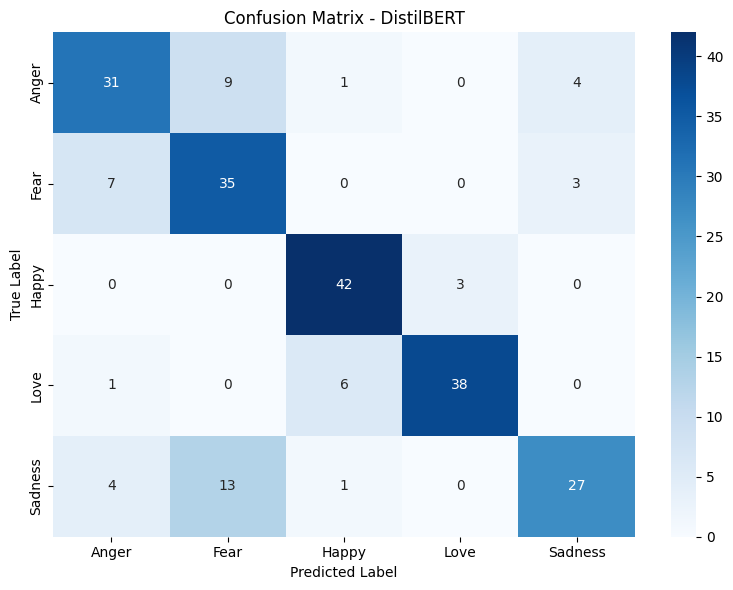

In [17]:
# --- CONFUSION MATRIX MULTICLASS ---
cm = confusion_matrix(y_true_id, y_pred_id)

# Ukuran figure disesuaikan untuk 5 kelas
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            # Gunakan TARGET_NAMES untuk label sumbu (5 label)
            xticklabels=TARGET_NAMES,
            yticklabels=TARGET_NAMES)

plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Simpan dan tampilkan
plt.savefig("confusion_matrix_emotion_multiclass.png", dpi=300)
print("\nConfusion matrix disimpan di 'confusion_matrix_emotion_multiclass.png'")
plt.show()

In [18]:
df_predictions

,teks_ulasan,prediksi_id,prediksi_emosi,probabilitas,waktu,ram,vram,label_asli
0,buah bagus kurir ok sellernya juga ok,2,Happy,0.954695,0.093578,9.605249,3.002136,Happy
1,ada sedikit cacat selain oke,2,Happy,0.972945,0.086110,9.605602,3.002136,Happy
2,jadi semangat mancing,2,Happy,0.969699,0.087812,9.603283,3.002136,Happy
3,cepat tiba n kemas bagus barang juga bagus,2,Happy,0.996709,0.085794,9.601057,3.002136,Happy
4,produk sesuai deskripsi variasi produk agam fu...,2,Happy,0.970216,0.086680,9.601086,3.002136,Happy
...,...,...,...,...,...,...,...,...
220,parah respon nya butuh 4 hari sejak order baru...,4,Sadness,0.426737,0.101541,9.683336,3.002136,Anger
221,buruk super duper buruk kok bisa rusakk dalam ...,0,Anger,0.882792,0.118469,9.682838,3.002136,Anger
222,kau kirim bareng bekas dan rusak serta tidak t...,0,Anger,0.950148,0.095936,9.682297,3.002136,Anger
223,jual kok ngotottt enggak laku toko nya bang,0,Anger,0.986234,0.105257,9.682114,3.002136,Anger
